## MLFLOW для экспериментов с PyTorch

__Как запустить сервер:__

Команды терминала:

Включим нужное окружение conda:

>conda activate "название окружения conda"

Запустим сервер:

>mlflow server --backend-store-uri "папка на компьютере, где будут храниться результаты"

В конце можно добавить нужный порт (автоматом 5000) --host localhost --port 5000

пример:
>mlflow server --backend-store-uri "file:///D:/ML_flow_server/data_local" --host localhost --port 5000


По этой ссылке будет доступен MLflow:

http://localhost:5000



In [1]:
import torch
import mlflow
import numpy as np # библиотека работы с матрицами на цпу
import random
import torch.nn as nn # модуль библиотеки для создрания слоев 
import matplotlib.pyplot as plt # библиотека для отображения графиков и изображений
import logging
%matplotlib inline

In [2]:
# Установка Seed для воспроизводимости
seed = 42
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
np.random.seed(seed)
random.seed(seed)
torch.backends.cudnn.benchmark = False
torch.backends.cudnn.deterministic = True

In [3]:
import torchvision.transforms as transforms
import torchvision.utils
import torch.nn as nn


train_mnist = torchvision.datasets.MNIST('data_mnist/train', train=True, 
                                                transform=transforms.Compose([transforms.ToTensor()]),  
                                                download=True)
test_mnist = torchvision.datasets.MNIST('data_mnist/test', train=False, 
                                               transform=transforms.Compose([transforms.ToTensor()]), 
                                               download=True)

batch_size = 256

train_loader = torch.utils.data.DataLoader(
                 dataset=train_mnist,
                 batch_size=batch_size,
                 shuffle=True)
test_loader = torch.utils.data.DataLoader(
                dataset=test_mnist,
                batch_size=batch_size,
                shuffle=False)

__Создадаим fc сеть:__

In [4]:
class FCNetwork(nn.Module):
    def __init__(self, prob, n_inside):
        super(FCNetwork, self).__init__() 
        self.fc1 = nn.Linear(784, n_inside)
        self.fc2 = nn.Linear(n_inside, 10)
        self.fc1_act = nn.ReLU()
        self.dropout = nn.Dropout(p = prob)

    def forward(self,x):
        x = x.view(-1,28*28)
        y = self.fc1(self.dropout(x))
        y = self.fc1_act(y)
        y = self.fc2(y)
        return y

## Пример без MLFlow:

In [5]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = FCNetwork(prob=0.5, n_inside=100)
model.to(device)

loss_func = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

# Функция для вычисления точности
def accuracy(y_pred, labels):
    preds = torch.argmax(y_pred, dim=1)
    return (preds == labels).float().mean().item()

Обучим сеть как обычно это делаем без трекинга в mlflow. Загружать будем локально на компьютер лучшую модель с мах test accuracy

In [6]:
maxacc = 0
N_epochs = 5

for epoch in range(N_epochs):
    epoch += 1
    model.train()
    train_loss = 0.0
    train_acc = 0.0
    train_samples = 0

    for itr, data in enumerate(train_loader):
        imgs = data[0].to(device)  # [B, H, W]
        labels = data[1].to(device)

        y_pred = model(imgs)  
        loss = loss_func(y_pred, labels)

        train_loss += loss.item() * imgs.size(0)
        train_acc += accuracy(y_pred, labels) * imgs.size(0)
        train_samples += imgs.size(0)

        if itr % 100 == 0:
            print('Epoch {}, Iteration {}, train accuracy {:.2f}, loss {:.4f}'.format(epoch, itr,
                                                                                     accuracy(y_pred, labels), loss))

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    train_loss /= train_samples
    train_acc /= train_samples
    print(f'The {epoch} Epoch of network learning is over:')
    print(f'Train results Epoch {epoch}: Train loss - {train_loss:.4f}, Train accuracy - {train_acc:.4f}')

    model.eval()
    test_loss = 0.0
    test_acc = 0.0
    test_samples = 0

    with torch.no_grad():
        for itr, data in enumerate(test_loader):
            imgs = data[0].to(device)
            labels = data[1].to(device)
            y_pred = model(imgs)
            loss = loss_func(y_pred, labels)

            test_loss += loss.item() * imgs.size(0)
            test_acc += accuracy(y_pred, labels) * imgs.size(0)
            test_samples += imgs.size(0)

    test_loss /= test_samples
    test_acc /= test_samples
    print(f'Validation results Epoch {epoch}: Test loss - {test_loss:.4f}, Test accuracy - {test_acc:.4f}')

    if test_acc > maxacc:
        print('Saving model because its better')
        maxacc = test_acc
        torch.save(model, f'mymodel_fc.pth')
    print('---')

Epoch 1, Iteration 0, train accuracy 0.12, loss 2.3032
Epoch 1, Iteration 100, train accuracy 0.63, loss 1.7995
Epoch 1, Iteration 200, train accuracy 0.76, loss 1.2474
The 1 Epoch of network learning is over:
Train results Epoch 1: Train loss - 1.6956, Train accuracy - 0.6011
Validation results Epoch 1: Test loss - 1.0384, Test accuracy - 0.8214
Saving model because its better
---
Epoch 2, Iteration 0, train accuracy 0.75, loss 1.1007
Epoch 2, Iteration 100, train accuracy 0.83, loss 0.7990
Epoch 2, Iteration 200, train accuracy 0.77, loss 0.7685
The 2 Epoch of network learning is over:
Train results Epoch 2: Train loss - 0.8647, Train accuracy - 0.8079
Validation results Epoch 2: Test loss - 0.6138, Test accuracy - 0.8694
Saving model because its better
---
Epoch 3, Iteration 0, train accuracy 0.82, loss 0.7099
Epoch 3, Iteration 100, train accuracy 0.84, loss 0.6359
Epoch 3, Iteration 200, train accuracy 0.85, loss 0.5896
The 3 Epoch of network learning is over:
Train results Epoch 

---

## Теперь воспользуемся MLFlow для трекинга экспериментов:

In [7]:
# Инициализация MLflow
#mlflow.set_tracking_uri("file:///D:/ML_flow_server/data_local")
mlflow.set_tracking_uri("http://localhost:5000")
mlflow.set_experiment("PyTorch_test")

<Experiment: artifact_location='mlflow-artifacts:/430964795819440425', creation_time=1730544467296, experiment_id='430964795819440425', last_update_time=1730544467296, lifecycle_stage='active', name='PyTorch_test', tags={}>

In [8]:
# Отключаем вывод ворнингов от MLflow
mlflow_logger = logging.getLogger("mlflow")
mlflow_logger.setLevel(logging.ERROR)

In [16]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
prob = 0.15
n_inside = 5000
lr = 3e-4
epochs = 12

In [17]:
# Начало MLflow запуска
with mlflow.start_run(run_name='FCNetwork_1') as run:
    model = FCNetwork(prob=prob, n_inside=n_inside)
    model.to(device)

    loss_func = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    mlflow.log_param("prob dropout", prob)
    mlflow.log_param("neurons 2 layer", n_inside)
    mlflow.log_param("lr", lr)
    mlflow.log_param("optimizer", 'Adam')
    mlflow.log_param("epochs", epochs)

    maxacc = 0
    itr_record = 0

    for epoch in range(epochs):
        epoch += 1
        model.train()
        train_loss = 0.0
        train_acc = 0.0
        train_samples = 0

        print(f'Началось обучение {epoch} эпохи')
        for itr, data in enumerate(train_loader):
            imgs = data[0].to(device)  # [B, H, W]
            labels = data[1].to(device)

            y_pred = model(imgs) 
            loss = loss_func(y_pred, labels)

            train_loss += loss.item() * imgs.size(0)
            train_acc += accuracy(y_pred, labels) * imgs.size(0)
            train_samples += imgs.size(0)

            if itr % 100 == 0:
                mlflow.log_metric("accuracy_batch_train", accuracy(y_pred, labels), step=itr_record)
                mlflow.log_metric("loss_batch_train", loss.item(), step=itr_record)
                itr_record += 1

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        train_loss /= train_samples
        train_acc /= train_samples
        mlflow.log_metric("train_loss", train_loss, step=epoch)
        mlflow.log_metric("train_acc", train_acc, step=epoch)
        print(f'The {epoch} Epoch of network learning is over:')
        print(f'Train results Epoch {epoch}: Train loss - {train_loss:.4f}, Train accuracy - {train_acc:.4f}')

        model.eval()
        test_loss = 0.0
        test_acc = 0.0
        test_samples = 0

        with torch.no_grad():
            for itr, data in enumerate(test_loader):
                imgs = data[0].to(device)
                labels = data[1].to(device)
                y_pred = model(imgs)
                loss = loss_func(y_pred, labels)

                test_loss += loss.item() * imgs.size(0)
                test_acc += accuracy(y_pred, labels) * imgs.size(0)
                test_samples += imgs.size(0)

        test_loss /= test_samples
        test_acc /= test_samples
        mlflow.log_metric("test_loss", test_loss, step=epoch)
        mlflow.log_metric("test_acc", test_acc, step=epoch)
        print(f'Validation results Epoch {epoch}: Test loss - {test_loss:.4f}, Test accuracy - {test_acc:.4f}')

        if test_acc > maxacc:
            print('Saving model because its better')
            maxacc = test_acc
            mlflow.pytorch.log_model(model, "model")
        print('---')

    print('max accuracy = ', maxacc)
    mlflow.log_metric("max test accuracy", maxacc)

mlflow.end_run()

Началось обучение 1 эпохи
The 1 Epoch of network learning is over:
Train results Epoch 1: Train loss - 0.4199, Train accuracy - 0.8902
Validation results Epoch 1: Test loss - 0.1983, Test accuracy - 0.9430
Saving model because its better
---
Началось обучение 2 эпохи
The 2 Epoch of network learning is over:
Train results Epoch 2: Train loss - 0.1817, Train accuracy - 0.9482
Validation results Epoch 2: Test loss - 0.1288, Test accuracy - 0.9620
Saving model because its better
---
Началось обучение 3 эпохи
The 3 Epoch of network learning is over:
Train results Epoch 3: Train loss - 0.1245, Train accuracy - 0.9643
Validation results Epoch 3: Test loss - 0.0987, Test accuracy - 0.9711
Saving model because its better
---
Началось обучение 4 эпохи
The 4 Epoch of network learning is over:
Train results Epoch 4: Train loss - 0.0955, Train accuracy - 0.9723
Validation results Epoch 4: Test loss - 0.0821, Test accuracy - 0.9757
Saving model because its better
---
Началось обучение 5 эпохи
The 5 

---

## Запуск обученной модели:

In [18]:
def load_model(model_uri):
    """Загрузка модели из MLflow."""
    model = mlflow.pytorch.load_model(model_uri)
    model.eval()  # Переводим модель в режим оценки
    return model

def predict(model, input_data):
    """Выполнение инференса."""
    with torch.no_grad():
        output = model(input_data)
    return output

In [19]:
model_uri = "runs:/de9d8e827cf5426ba171b3ed79b905ca/model"  # Замените <run_id> на реальный идентификатор запуска
loaded_model = load_model(model_uri).to(device)

# Пример входных данных
input_data = torch.randn(1, 1, 28, 28).to(device)

# Выполнение инференса
output = predict(loaded_model, input_data)
print(output)

tensor([[-4.1135e-01, -8.4279e-01, -4.9572e+00,  1.1015e+00, -6.3620e+00,
          3.9915e+00, -5.3242e+00,  2.1129e+00, -2.0704e+00, -3.5215e-03]],
       device='cuda:0')


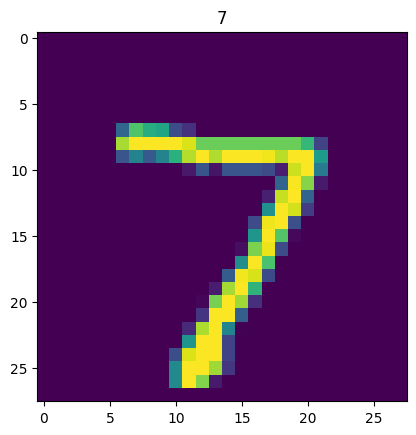

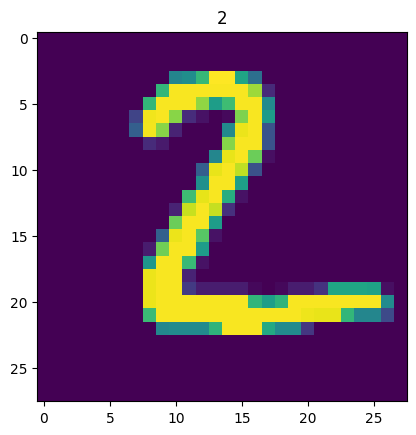

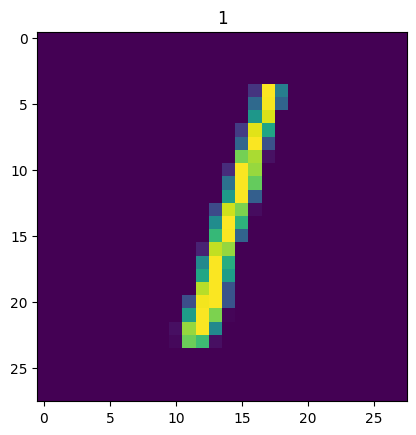

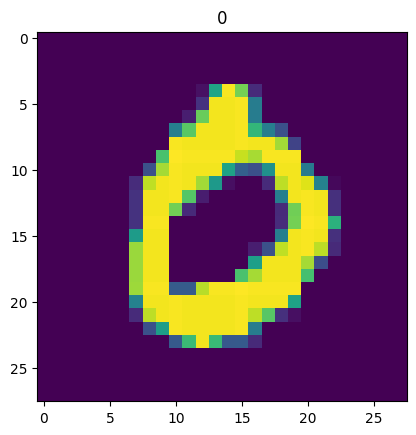

In [21]:
model.eval()
with torch.no_grad():
    for itr,data in enumerate(test_loader):
        if itr == 0:
            imgs = data[0].to(device)   #b,c,w,h
            labels = data[1].to(device)
            y_pred = predict(loaded_model, imgs)
            y_pred = torch.argmax(y_pred, dim=1)
            for i in range(4):
                im = np.transpose((imgs[i].cpu().numpy()), (1, 2, 0))
                plt.figure()
                plt.imshow(im)  #w,h,c
                plt.title(y_pred[i].cpu().numpy())
                plt.show()

___